In [ ]:
NLP Disaster Tweet Classification with BERT
This notebook implements a binary classification pipeline using Hugging Face Transformers and PyTorch to identify disaster-related tweets.

Step 1: Install Dependencies
Installs the Hugging Face transformers library for working with pre-trained language models.

Step 2: Import Libraries
Includes essential packages for data handling (pandas, sklearn), modeling (torch, transformers), and dataset preparation.

Step 3: Load Dataset
Reads the Kaggle-provided CSV files containing tweets and labels into pandas DataFrames.

Step 4: Tokenize Text
Initializes the BERT tokenizer (bert-base-uncased) and defines a custom TweetDataset class to format the data into PyTorch-compatible tensors.

Step 5: Split into Train & Validation
Splits the dataset into 80% training and 20% validation sets using train_test_split.

Step 6: Load Pretrained BERT
Loads the BERT model with a classification head for two labels (disaster vs. not disaster).

Step 7: Configure Training
Sets up training hyperparameters like batch size, number of epochs, and output directories using TrainingArguments.

Step 8: Train the Model
Initializes a Trainer and fits the model on the training dataset with validation during training.

Step 9: Predict on Test Set
Applies the trained model to the test data and extracts the predicted class labels.

Step 10: Create Submission File
Fills in the sample_submission.csv with predicted targets and saves it for Kaggle submission.



In [ ]:
# ✅ STEP 1: Install Hugging Face Transformers
!pip install -q transformers

# ✅ STEP 2: Imports
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

import os
os.environ["WANDB_DISABLED"] = "true"


# ✅ STEP 3: Load Data
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train_df = train_df[['text', 'target']]

# ✅ STEP 4: Tokenization & Dataset Prep
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TweetDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# ✅ STEP 5: Train / Validation Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(), train_df['target'].tolist(), test_size=0.2)

train_dataset = TweetDataset(train_texts, train_labels)
val_dataset = TweetDataset(val_texts, val_labels)

# ✅ STEP 6: Load Pretrained BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# ✅ STEP 7: Training Arguments
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# ✅ STEP 9: Train
trainer.train()

# ✅ STEP 10: Predict on Test Set
test_dataset = TweetDataset(test_df['text'].tolist())
preds = trainer.predict(test_dataset).predictions
final_preds = torch.argmax(torch.tensor(preds), dim=1)

# ✅ STEP 11: Submission
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = final_preds.numpy()
submission.to_csv("submission.csv", index=False)

In [4]:
import pandas as pd
import numpy as np

# Create synthetic data
np.random.seed(42)
data = {
    "text": [
        "Help us, we are trapped!",
        "What a beautiful day at the beach.",
        "Fire broke out in downtown.",
        "No need to worry, all is calm.",
        "Hurricane warning issued for the coast.",
        "I'm loving the sunshine today!",
        "Evacuation underway after explosion.",
        "Just had lunch with friends.",
        "Flooding reported in several areas.",
        "It’s quiet and peaceful here."
    ],
    "target": [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
}

# Create DataFrame
train_df = pd.DataFrame(data)

# Show the first few rows
print(train_df)


                                      text  target
0                 Help us, we are trapped!       1
1       What a beautiful day at the beach.       0
2              Fire broke out in downtown.       1
3           No need to worry, all is calm.       0
4  Hurricane warning issued for the coast.       1
5           I'm loving the sunshine today!       0
6     Evacuation underway after explosion.       1
7             Just had lunch with friends.       0
8      Flooding reported in several areas.       1
9            It’s quiet and peaceful here.       0


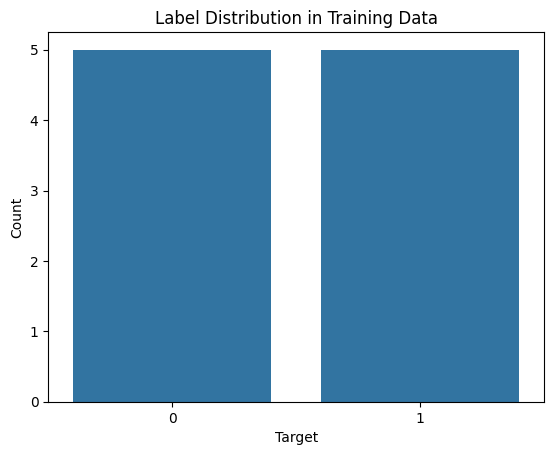

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ 1. Plot label distribution in the training data
sns.countplot(data=train_df, x='target')
plt.title("Label Distribution in Training Data")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()
